# Using PACE data to determine biogeographic regions with K-Means clustering
#### PACE Hackweek 2024 August 4-8
#### Group: KAE-Means (Kimberly Hyde, Aliya Jamil, Kitty Kam, Ellen Park)

## Project Goal
- Use PACE data and K-Means clustering to identify different water types/biogeographic regions in the western Atlantic

## Learning Objectives
- Learn Python
- Improve with GitHub
## Contents


```mermaid
%%{init: { 'flowchart': { 'curve': 'monotoneY' } } }%%

flowchart LR

A[(PACE satellite)] -->|Chla| C{K-means clustering}
A -->|AVW| C
A -->|FLH| C
A -->|POC| C
A -->|Kd| C
B[(Merged products)] --> |SST| C


C --> |Cluster IDs| D(Regions)

D --> Hyperspectral-Rrs
D --> PCC
D --> Size-Class
```

Install proper external packages.\
[argopy](https://argopy.readthedocs.io/en/latest/) (Python library for accessing Argo float data)

In [1]:
%pip install gapstatistics
%pip install argopy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import necessary libraries

In [27]:
import sys
sys.path.append('functions/')
# group developed functions for getting data
from cluster_fxns import GetOptimalK, GetSurfaceFloatValues, Regrid, GetData, GetMOANAMeans, GetClosestCluster
from get_nFLH import get_nFLH
from Rrs_avg import  Rrs_avg

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cmocean
from datetime import datetime
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree
import glob
import xarray as xr
from xarray.backends.api import open_datatree
import cartopy.crs as ccrs
from PIL import Image, ImageEnhance
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

## Materials and Methods

### What PACE data will we use to create our clusters and why?
- Chlorophyll
- Apparent visible wavelength
- Particulate organic carbon
- Diffuse attenuation coefficient: How light attenuates in the water column
- Fluorescence line height
- Other data:
  - Sea surface temperature (ACSPO)

Specify our region and time period for study

In [2]:
latN = 50; latS = 20; lonW = -80; lonE = -45
date_range = ['2024-07-19','2024-08-03']

Get our satellite data of interest with our functions. SST is an 8-day avergae from [ACSPO](https://coastwatch.noaa.gov/cwn/processing-algorithms/acspo.html). Advanced Clear Sky Processor for Ocean (ACSPO) is the NOAA Enterprise SST system.

In [3]:
SST, AVW, CHL, POC, KD, RRS = GetData(latN, latS, lonW, lonE, date_range)

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Regrid SST and AVW to chlorophyll grid using griddata

In [4]:
LO, LA = np.meshgrid(CHL.lon.values, CHL.lat.values)

avw = Regrid(AVW.avw.values, (AVW.lon.values, AVW.lat.values), (LO,LA))
sst = Regrid(SST.values, (SST.longitude.values, SST.latitude.values), (LO,LA))

Calculate fluorescence line high (FLH). How did we calculate FLH?
- Add notes on methods here. What assumptions did we make?

Fluorescence line height calculation relies on three wavelengths:
1. Chlorophyll fluorescence peak ($\lambda_F$)
2. A shorter waveband of the fluorescence peak ($\lambda_L$)
3. A longer waveband than fluorescence peak ($\lambda_H$)


<img src="FLH_schematic.png" width="500" height="340">


**Workflow**:

Rrs is converted to normalized water-leaving radiance (nLw) using a solar irradiance spectrum (F0, [TSIS version](https://oceancolor.gsfc.nasa.gov/resources/docs/rsr_tables/)): 

$$nLw(\lambda) = Rrs(\lambda) \times F_0(\lambda)$$

Normalized fluorescence line height (unit: $mW cm^{-2} \mu m^{-1} sr^{-1}$) can be calculated using this relationship:

$$nFLH = nLw(\lambda_F) - \big(\frac{\lambda_H - \lambda_F}{\lambda_H - \lambda_L} \big) \times nLw(\lambda_L) - \big(\frac{\lambda_L - \lambda_F}{\lambda_H - \lambda_L} \big) \times nLw(\lambda_H) $$

$$
\begin{cases}
    \lambda_F = 678 nm \\
    \lambda_L = 660 nm \\
    \lambda_L = 706 nm
\end{cases}
$$



**Reference** :

* Behrenfeld, M. J., Westberry, T. K., Boss, E. S., et al. (2009). Satellite-detected fluorescence reveals global physiology of ocean phytoplankton. Biogeosciences 6, 779-795. [http://dx.doi.org/10.5194/bgd-5-4235-2008](http://dx.doi.org/10.5194/bgd-5-4235-2008)
* [Ocean Colour data description - normalized Fluorescence Line Height (nFLH)](https://oceancolor.gsfc.nasa.gov/resources/atbd/nflh/)
* Conversation with Jeremy :)

In [5]:
FLH = []
for rrs in RRS:
    flh = get_nFLH(rrs)
    FLH.append(flh)
FLH = np.concatenate((FLH[0].Rrs.values.reshape(1,LO.shape[0],LO.shape[1]),
                      FLH[1].Rrs.values.reshape(1,LO.shape[0],LO.shape[1])))

In [6]:
desired_wavelength = 475
# format data
X = pd.DataFrame({'CHL': CHL.chlor_a.values.flatten(),
                 'AVW': avw.flatten(),
                  'SST': sst.flatten(),
                  'POC': POC.poc.values.flatten(),
                  'KD': KD.Kd.values[:,:, :, np.where(KD.wavelength == desired_wavelength)[0]].flatten(),
                  'FLH': FLH.flatten(),
                  #'LON': np.concatenate((LO.reshape(1,LO.shape[0],LO.shape[1]),LO.reshape(1,LO.shape[0],LO.shape[1]))).flatten(),
                  #'LAT': np.concatenate((LA.reshape(1,LO.shape[0],LO.shape[1]),LA.reshape(1,LO.shape[0],LO.shape[1]))).flatten()
                 })
# Address NaN's
good_inds = np.where(X.isna().sum(axis = 1)==0)[0]
nan_inds = np.where(X.isna().sum(axis = 1)>0)[0]

X = X.iloc[good_inds, :]

# Standardize input feautres
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

### Let's visualize these input data in our region!

/tmp/ipykernel_1212/4094385233.py:17: RuntimeWarning: Mean of empty slice
  cc = ax.pcolormesh(LO, LA, np.nanmean(data[fi],axis=0), cmap = cmaps[fi],
/tmp/ipykernel_1212/4094385233.py:17: RuntimeWarning: Mean of empty slice
  cc = ax.pcolormesh(LO, LA, np.nanmean(data[fi],axis=0), cmap = cmaps[fi],
/tmp/ipykernel_1212/4094385233.py:17: RuntimeWarning: Mean of empty slice
  cc = ax.pcolormesh(LO, LA, np.nanmean(data[fi],axis=0), cmap = cmaps[fi],
/tmp/ipykernel_1212/4094385233.py:17: RuntimeWarning: Mean of empty slice
  cc = ax.pcolormesh(LO, LA, np.nanmean(data[fi],axis=0), cmap = cmaps[fi],
/tmp/ipykernel_1212/4094385233.py:17: RuntimeWarning: Mean of empty slice
  cc = ax.pcolormesh(LO, LA, np.nanmean(data[fi],axis=0), cmap = cmaps[fi],
/tmp/ipykernel_1212/4094385233.py:17: RuntimeWarning: Mean of empty slice
  cc = ax.pcolormesh(LO, LA, np.nanmean(data[fi],axis=0), cmap = cmaps[fi],


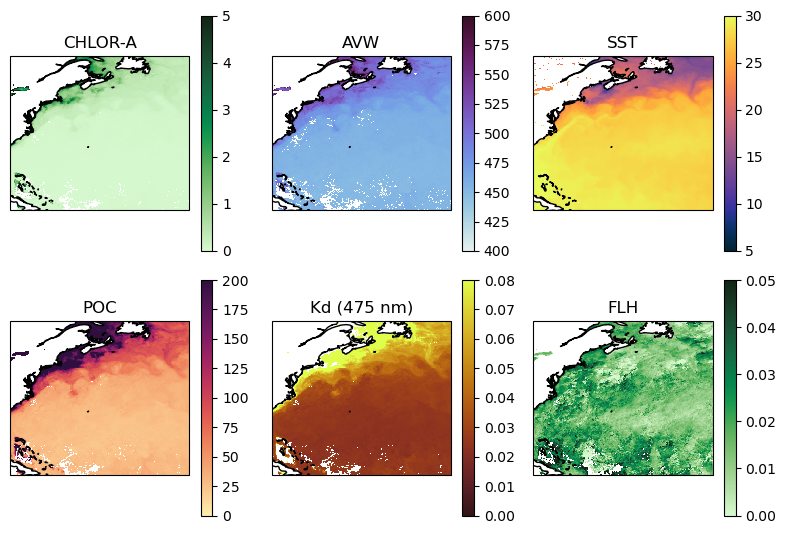

In [7]:
# Let's visualize mean input data
data = [CHL.chlor_a.values, avw, sst,
        POC.poc.values,
        KD.Kd.values[:,:, :, np.where(KD.wavelength == desired_wavelength)[0]][:,:,:,0],
       FLH]
labels = ['CHLOR-A','AVW','SST','POC','Kd (475 nm)', 'FLH']
min_max = [[0,5],[400, 600], [5,30],[0,200],[0,0.08],[0,0.05]]
cmaps = [cmocean.cm.algae, cmocean.cm.dense, cmocean.cm.thermal, cmocean.cm.matter, cmocean.cm.solar,  cmocean.cm.algae]

fig = plt.figure(figsize = (8,8))
rows = 3; cols = 3

for fi in np.arange(len(data)):
    
    ax = fig.add_subplot(rows,cols, int(fi+1), projection=ccrs.PlateCarree())

    cc = ax.pcolormesh(LO, LA, np.nanmean(data[fi],axis=0), cmap = cmaps[fi],
                      vmin = min_max[fi][0], vmax = min_max[fi][1])
    fig.colorbar(cc, ax = ax)
    ax.set_title(labels[fi])
    ax.coastlines()


fig.tight_layout()

### How will we make our clusters?
We will use K-means to create our clusters.

#### What is K-means?

An important thing to consider is "What is the appropriate number of clusters?" To address this question we tried the Elbow Method and Gap Statistics.

#### The Elbow Method

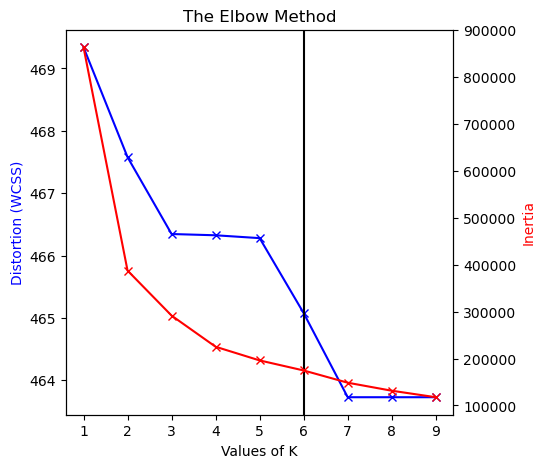

In [8]:
distortions = []
inertias = []
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_scaled)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
    
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
axt = ax.twinx()
ax.plot(K, distortions, 'bx-')
axt.plot(K, inertias, 'rx-')
ax.set_xlabel('Values of K')
ax.set_ylabel('Distortion (WCSS)', color = 'b')
axt.set_ylabel('Inertia',color = 'r')
ax.set_title('The Elbow Method')
ax.axvline(6, color = 'k')

From [GeeksforGeeks](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)\
"**Distortion**: It is calculated as the average of the squared distances from the cluster centers of the respective clusters to each data point. Typically, the Euclidean distance metric is used.\
**Inertia**: It is the sum of the squared distances of samples to their closest cluster center." \

From [Medium](https://medium.com/@tiami.abiola/clustering-wcss-and-elbow-method-427db8968ba1)\
**WCSS**: Within-Cluster Sum of Squares. "The Within-Cluster Sum of Squares (WCSS) and the Elbow Method are important concepts in the context of clustering algorithms, especially for techniques like K-Means. WCSS is a measure of the compactness or cohesion of clusters in a clustering algorithm, particularly K-Means. It quantifies how close data points within a cluster are to the centroid of that cluster."

#### Gap Statistics

In [12]:
# Determine optimal number of clusters
# Randomly sample some fraction because data is too big
frac = 0.01
rows_id = random.sample(range(0, X_scaled.shape[0]-1), int(X_scaled.shape[0]*frac))
gs, optimum_k = GetOptimalK(10, X_scaled[rows_id,:])
print('Optimum number of clusters: ',optimum_k)

# Note: plotting takes forever
# gs.plot()

Optimum number of clusters:  8


## Preliminary Results
Now that, we've determined the optimal number of clusters to use. We can create our clusters! For now, we are using 6 clusters.

In [9]:
optimum_k = 6
kmeans_fit = KMeans(n_clusters=optimum_k).fit(X_scaled)
labels = kmeans_fit.predict(X_scaled)

# Add labels back to dataset and reshape
total_labels = np.zeros(CHL.chlor_a.shape)*np.NaN
total_labels[np.unravel_index(good_inds, total_labels.shape)]=labels

In [12]:
# Save out labels
cluster_df = xr.DataArray(
    data=total_labels,
    dims=[ "time","x", "y",],
    coords=dict(
        lon=(["x", "y"], LO),
        lat=(["x", "y"], LA),
        time=(["time"], np.arange(2)),
    ),
)
## da.to_netcdf('/home/jovyan/shared-public/KAE_means/labels.nc')

#### How to the clusters change spatially with time?

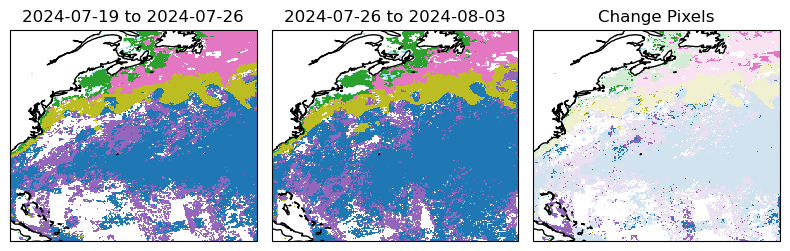

In [11]:
date_range = [['2024-07-19','2024-07-26'],['2024-07-26','2024-08-03']]
fig = plt.figure(figsize = (8,4))
rows = 1; cols = 3;
cmap = 'tab20'
for i in np.arange(2):
    ax = fig.add_subplot(rows, cols, int(i+1), projection=ccrs.PlateCarree())
    ax.pcolormesh(LO, LA, total_labels[i,:,:],cmap =cmap)
    ax.coastlines()

    ts = date_range[i][0]+' to '+ date_range[i][1]
    ax.set_title(ts)

change_points = np.where(((total_labels[0,:,:]-total_labels[1,:,:]) != 0) & \
                         np.isnan(total_labels[0,:,:]-total_labels[1,:,:])==False, 1, np.NaN)

ax = fig.add_subplot(rows, cols, int(i+2), projection=ccrs.PlateCarree())
ax.pcolormesh(LO, LA, total_labels[0,:,:], cmap = cmap)
ax.pcolormesh(LO, LA, change_points, cmap = 'Greys', alpha = 0.8)
ax.set_title('Change Pixels')
fig.tight_layout()
ax.coastlines()

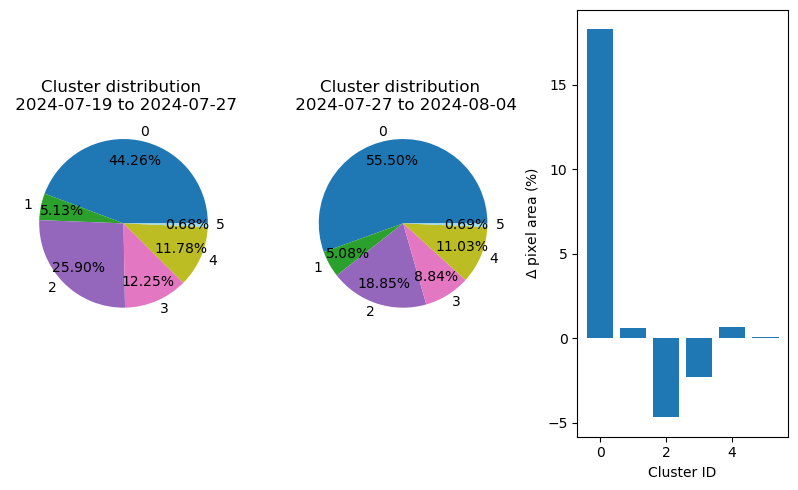

In [17]:
#take a slice
id_tsp_1 = cluster_df.values[0,:,:]
id_tsp_2 = cluster_df.values[1,:,:]
unique_tsp_1, count_tsp_1 = np.unique(id_tsp_1[~np.isnan(id_tsp_1)], return_counts = True)
unique_tsp_2, count_tsp_2 = np.unique(id_tsp_2[~np.isnan(id_tsp_2)], return_counts = True)

cmapp = plt.cm.tab20(np.linspace(0,1,optimum_k))
# Piechart
tspan = ("2024-07-19", "2024-07-27")

fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(1,3,1)
#plot 1
ax.set_title('Cluster distribution \n 2024-07-19 to 2024-07-27')
ax.pie(count_tsp_1,labels = unique_tsp_1.astype(int), autopct='%1.2f%%', colors = cmapp, pctdistance=0.75)

#plot 2
ax = fig.add_subplot(1,3,2)
ax.set_title('Cluster distribution \n 2024-07-27 to 2024-08-04')
ax.pie(count_tsp_2,labels = unique_tsp_2.astype(int), autopct='%1.2f%%', colors = cmapp, pctdistance=0.75)

# barchart : difference between 2 composite
diff = (count_tsp_2 - count_tsp_1)/np.sum(count_tsp_1)*100

# bar 
ax = fig.add_subplot(1,3,3)

ax.bar(unique_tsp_1.astype(int),diff)
ax.set_xlabel('Cluster ID')
ax.set_ylabel('$\Delta$ pixel area (%)')

fig.tight_layout()

In [18]:
def PlotReferenceMaps():
    date_range = [['2024-07-19','2024-07-26'],['2024-07-26','2024-08-03']]
    fig = plt.figure(figsize = (8,4))
    rows = 1; cols = 2;
    cmap = 'tab20'
    for i in np.arange(2):
        ax = fig.add_subplot(rows, cols, int(i+1), projection=ccrs.PlateCarree())
        cc = ax.pcolormesh(LO, LA, total_labels[i,:,:],cmap =cmap)
        ax.coastlines()
    
        ts = date_range[i][0]+' to '+ date_range[i][1]
        ax.set_title(ts)
    
        if i == 1:
            fig.colorbar(cc, ax = ax)
    return

## How can we evaluate these clusters?
Validation data sets:
1) PACE Rrs
2) Phytoplankton Community Composition (PCC): PACE MOANA phytoplankton & (Other)
3) Biogeochemical Argo floats

### PACE Rrs: What does the average spectra look like in each cluster?
If the hyperspectral Rrs spectra are 

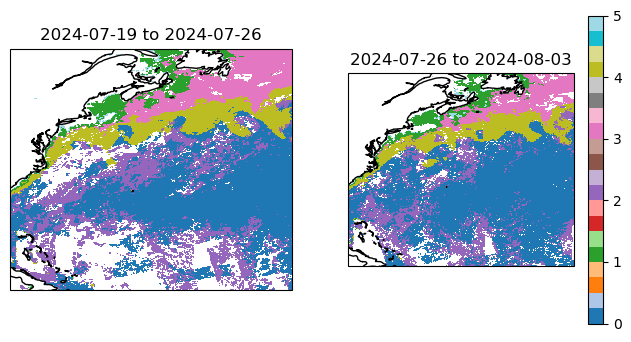

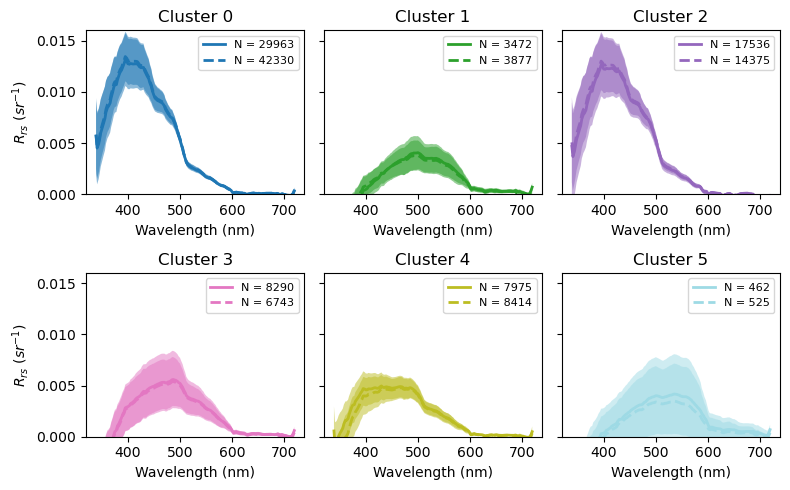

In [19]:
PlotReferenceMaps()

RRS_list = RRS
line_style  = ['-','--']

fig = plt.figure(figsize = (8,5))

rows = 2; cols = 3
cmap = 'tab20'
cmapp = plt.cm.tab20(np.linspace(0,1,optimum_k))
for fi in np.arange(optimum_k):


    ax = fig.add_subplot(rows,cols,int(fi+1))
        
    # Get mean spectra
    for ri in np.arange(len(RRS_list)):

        rrs = RRS_list[ri]
        mean, sd, wv = Rrs_avg(rrs,total_labels[ri,:,:], fi)
        
        ax.plot(wv, mean, lw=2, color=cmapp[int(fi),:], linestyle = line_style[ri],
               label = 'N = '+str(np.where(total_labels[ri,:,:]==fi)[0].shape[0]))
        ax.fill_between(wv, mean+sd, mean-sd, facecolor=cmapp[int(fi),:], alpha=0.5)
    ax.set_ylim([0,0.016])
    ax.set_xlabel('Wavelength (nm)')
    ax.legend(fontsize = 8,loc = 'upper right')
    if (fi+1)%cols != 1:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('$R_{rs} \ (sr^{-1})$')

    ts = 'Cluster '+str(int(fi))
    ax.set_title(ts)
    
fig.tight_layout()

## PCC: How do the PACE MOANA phytoplankton assemblages vary between clusters? 

Priscila Kienteca Lange, P. Jeremy Werdell, Zachary K. Erickson, Giorgio Dall’Olmo, Robert J. W. Brewin, Mikhail V. Zubkov, Glen A. Tarran, Heather A. Bouman, Wayne H. Slade, Susanne E. Craig, Nicole J. Poulton, Astrid Bracher, Michael W. Lomas, and Ivona Cetinić, "Radiometric approach for the detection of picophytoplankton assemblages across oceanic fronts," Opt. Express 28, 25682-25705 (2020)

In [21]:
MO_file = 'data/PACE_OCI.20240729T173723.L2_MOANA.V2.nc'
prod = xr.open_dataset(MO_file, group="geophysical_data")
nav = xr.open_dataset(MO_file, group='navigation_data')
dataset = xr.merge((prod, nav))
dataset = dataset.set_coords(("longitude", "latitude"))

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


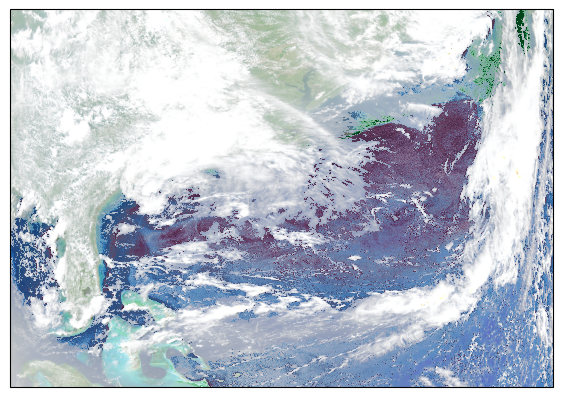

In [28]:
vmin = 0.01
vmax = 1.04 # Above 1 because whites can be higher than 1
#---- 
rhos_red = dataset["rhos_645"]
rhos_green = dataset["rhos_555"]
rhos_blue = dataset["rhos_465"]
red = np.log(rhos_red/0.01)/np.log(1/0.01)
green = np.log(rhos_green/0.01)/np.log(1/0.01)
blue = np.log(rhos_blue/0.01)/np.log(1/0.01)
red = red.where((red >= vmin) & (red <= vmax), vmin, vmax)
green = green.where((green >= vmin) & (green <= vmax), vmin, vmax)
blue = blue.where((blue >= vmin) & (blue <= vmax), vmin, vmax)
rgb = np.dstack((red, green, blue))
rgb = (rgb -  np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb)) #normalize

# RBG Image adjustments: 
contrast = 1.35
brightness = 1 
sharpness = 2
saturation = 1.3
gamma = .43
#----
normalized_image = (rgb - rgb.min()) / (rgb.max() - rgb.min())
normalized_image = normalized_image** gamma
normalized_image = (normalized_image* 255).astype(np.uint8)
image_pil = Image.fromarray(normalized_image)
enhancer = ImageEnhance.Contrast(image_pil)
image_enhanced = enhancer.enhance(contrast)  
enhancer = ImageEnhance.Brightness(image_enhanced)
image_enhanced = enhancer.enhance(brightness)  
enhancer = ImageEnhance.Sharpness(image_enhanced)
image_enhanced = enhancer.enhance(sharpness)
enhancer = ImageEnhance.Color(image_enhanced)
image_enhanced = enhancer.enhance(saturation)
enhanced_image_np = np.array(image_enhanced) / 255.0  # Normalize back to [0, 1] range

# Set colormaps for different groups
cmap_greens = pl.cm.Greens # Get original color map
my_cmap_greens = cmap_greens(np.arange(cmap_greens.N)) 
my_cmap_greens[:,-1] = np.linspace(0, 1, cmap_greens.N) # Set alpha for transparency
my_cmap_greens = ListedColormap(my_cmap_greens) # Create new colormap
cmap_reds = pl.cm.Reds
my_cmap_reds = cmap_reds(np.arange(cmap_reds.N))
my_cmap_reds[:,-1] = np.linspace(0, 1, cmap_reds.N)
my_cmap_reds = ListedColormap(my_cmap_reds)
cmap_blues = pl.cm.Blues
my_cmap_blues = cmap_blues(np.arange(cmap_blues.N))
my_cmap_blues[:,-1] = np.linspace(0, 1, cmap_blues.N)
my_cmap_blues = ListedColormap(my_cmap_blues)

# Map the groups ontop of the true color image
fig = plt.figure(figsize=(7, 7))
axes = plt.subplot(projection=ccrs.PlateCarree())
extent=(dataset.longitude.min(), dataset.longitude.max(), dataset.latitude.min(), dataset.latitude.max())
axes.imshow(enhanced_image_np, extent=extent, origin='lower', transform=ccrs.PlateCarree(), alpha=0.8)
axes.imshow(dataset["prococcus_moana"], extent=extent, origin='lower', transform=ccrs.PlateCarree(), interpolation='none', cmap=my_cmap_blues, vmin=0, vmax=300000, alpha = .8)
axes.imshow(dataset["syncoccus_moana"], extent=extent, origin='lower', transform=ccrs.PlateCarree(), interpolation='none', cmap=my_cmap_reds, vmin=0, vmax=20000, alpha = .5)
axes.imshow(dataset["picoeuk_moana"], extent=extent, origin='lower', transform=ccrs.PlateCarree(), interpolation='none', cmap=my_cmap_greens, vmin=0, vmax=50000, alpha = 1)

In [29]:
# Get MOANA files
flist = glob.glob('data/PACE*.nc')

# Compute statistics
moana_mean, moana_variance = GetMOANAMeans(flist, optimum_k, LO, LA, total_labels)

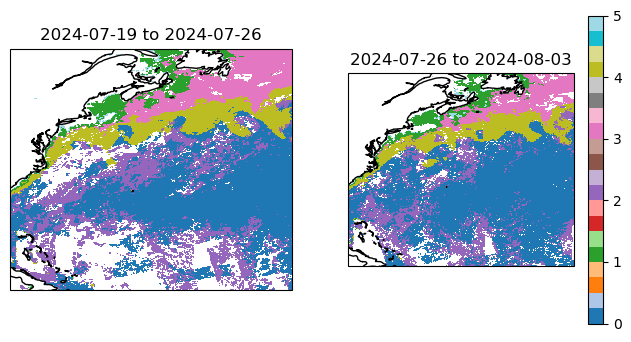

<Figure size 1200x500 with 0 Axes>

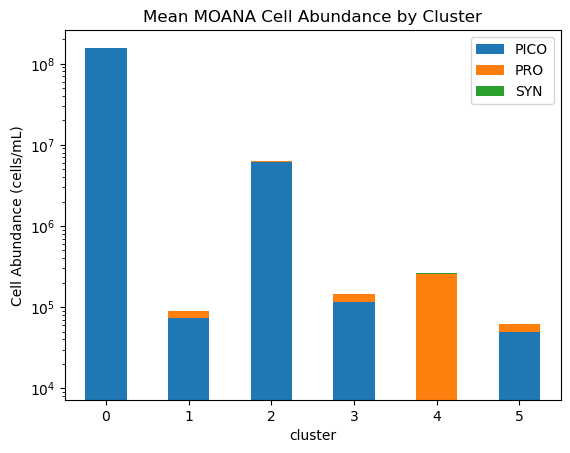

In [30]:
PlotReferenceMaps()

pcc_list =[ 'picoeuk_moana','prococcus_moana','syncoccus_moana']
fig = plt.figure(figsize = (12,5))

rows = 1; cols = optimum_k


df = pd.DataFrame({'cluster': np.arange(optimum_k),
                   'PICO': moana_mean[:,0],
                   'PRO': moana_mean[:,1],
                   'SYN': moana_mean[:,2]})


df.plot(x='cluster', kind='bar', stacked=True,
        title='Mean MOANA Cell Abundance by Cluster')
plt.ylabel('Cell Abundance (cells/mL)')
plt.yscale("log")
plt.xticks(rotation=0)
fig.tight_layout()

### PCC: How do the phytoplankton size classes vary between clusters?

#### Summary
Phytoplankton size class fractions were derived from the Northeast U.S. continental shelf PSC model by Turner et. al (2021). The regional re-parameterized abundance model incorporates sea surface temperature and performs significantly better in the Northeast compared to other global models. 

#### References
https://doi.org/10.1016/j.rse.2021.112729

<img src="Turner_paper.png" width="600" height="100">

Available parameters
- fpico
- fnanopico
- fnano
- fmicro

/tmp/ipykernel_1212/1374030517.py:10: RuntimeWarning: Mean of empty slice
  cc = ax.pcolormesh(LO, LA, np.nanmean(data[pcc_list[fi]].values,axis = 0),vmin = 0, vmax = 0.6)


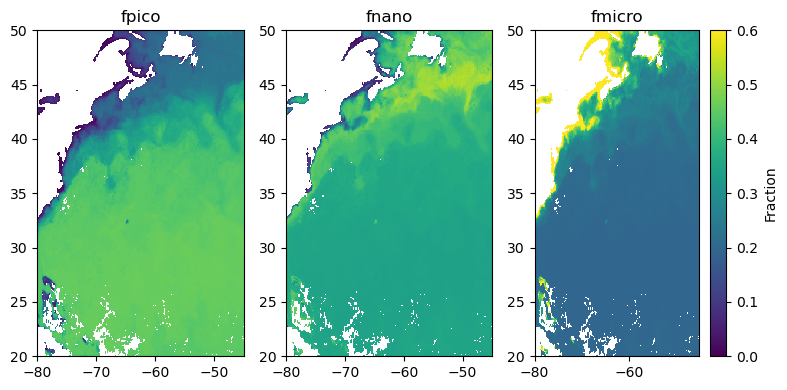

In [31]:
data = xr.open_dataset('data/psize_output.nc')
data.close()

pcc_list = ['fpico','fnano','fmicro']

fig = plt.figure(figsize = (8,4))

for fi in np.arange(len(pcc_list)):
    ax = fig.add_subplot(1,len(pcc_list), int(fi+1))              
    cc = ax.pcolormesh(LO, LA, np.nanmean(data[pcc_list[fi]].values,axis = 0),vmin = 0, vmax = 0.6)

    if fi == len(pcc_list)-1:
        fig.colorbar(cc, ax = ax, label = 'Fraction')

    ax.set_title(pcc_list[fi])
fig.tight_layout()

In [32]:
size_means = np.zeros((optimum_k, len(pcc_list)))*np.NaN

for ci in np.arange(optimum_k):
    inds = np.where(total_labels == ci)

    for pi in np.arange(len(pcc_list)):
        size_means[ci,pi] = np.nanmean(data[pcc_list[pi]].values[inds])

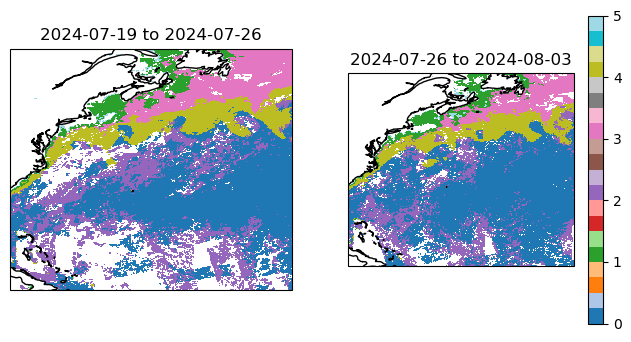

<Figure size 640x480 with 0 Axes>

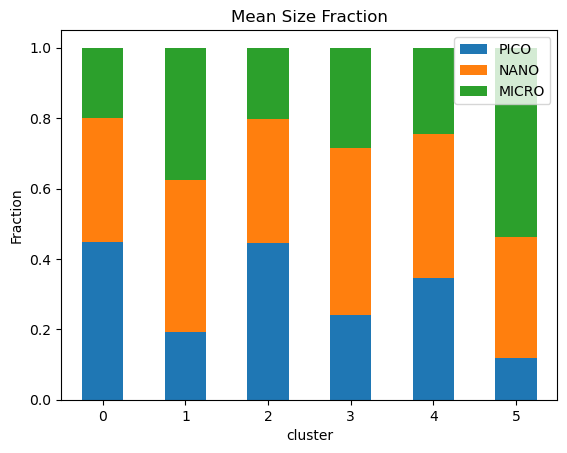

In [33]:
PlotReferenceMaps()
###
df = pd.DataFrame({'cluster': np.arange(optimum_k),
                   'PICO': size_means[:,0],
                   'NANO': size_means[:,1],
                   'MICRO': size_means[:,2]})

plt.figure()
df.plot(x='cluster', kind='bar', stacked=True,
        title='Mean Size Fraction')
plt.ylabel('Fraction')
#plt.yscale("log")
plt.xticks(rotation=0)
fig.tight_layout()

### BGC-Argo Floats: What are the surface biogeochemical properties like in each cluster?
Get the BGC-Argo data using the argopy toolbox

In [35]:
# get float values: note this takes a decent amounts of time
download_float_data = False
parameter_list = ['DOXY','CHLA', 'BBP700', 'CDOM', 'PH_IN_SITU_TOTAL', 'NITRATE']
if download_float_data == True:
    
    float_values = GetSurfaceFloatValues([latN, latS, lonE, lonW], date_range, parameter_list,
                                        want_all=False)
    float_values.to_pickle('data/float_values.pkl')
else:
    float_values = pd.read_pickle('data/float_values.pkl')

# Get cluster labels
tree = KDTree(np.c_[LO.ravel(),LA.ravel()])
float_labels = np.zeros(float_values.shape[0])*np.NaN

for ti in np.arange(float_values.shape[0]):
    dd, ii = tree.query([float_values.loc[:,'longitude'].values[ti],float_values.loc[:,'latitude'].values[ti]])

    # Get data period 
    if float_values.loc[:,'date'].values[ti] < np.datetime64('2024-07-27'):
        si = 0
    else:
        si = 1

    inds = np.unravel_index(ii,LO.shape)
    float_labels[ti] = total_labels[si,inds[0], inds[1]]

# Assign labels
float_values = float_values.assign(FLAG = float_labels)   

#### Where are the floats located in the region?

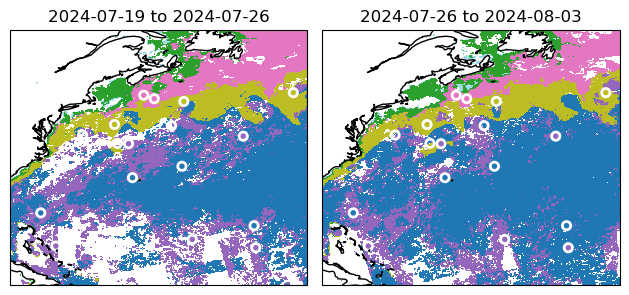

In [36]:
fig = plt.figure()
rows = 1; cols = 2;
for i in np.arange(2):
    ax = fig.add_subplot(rows, cols, int(i+1), projection=ccrs.PlateCarree())
    ax.pcolormesh(LO, LA, total_labels[i,:,:],cmap =cmap)

    float_inds = np.where(float_values.loc[:,'date'].values < np.datetime64('2024-07-27'))
    
    ax.scatter(float_values.loc[:,'longitude'].values[float_inds], float_values.loc[:,'latitude'].values[float_inds],
               c = float_values.loc[:,'FLAG'].values[float_inds], edgecolor = 'w',
              vmin = 0, vmax = optimum_k-1,cmap =cmap, linewidth = 2)
    ax.coastlines()
    ts = date_range[i][0]+' to '+ date_range[i][1]
    ax.set_title(ts)

fig.tight_layout()

#### What are the mean surface conditions in each cluster?
Plot the data by cluster looking at mean QCd data (flags: 1,2) in the upper 50m

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mea

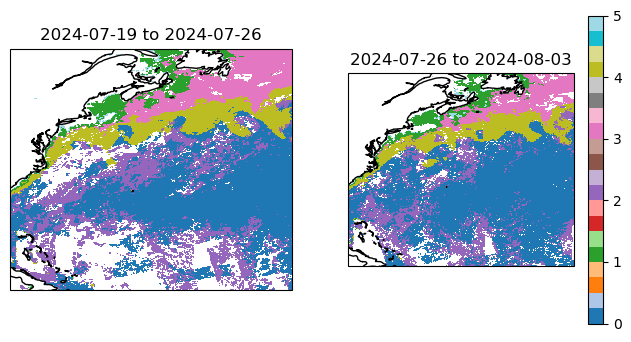

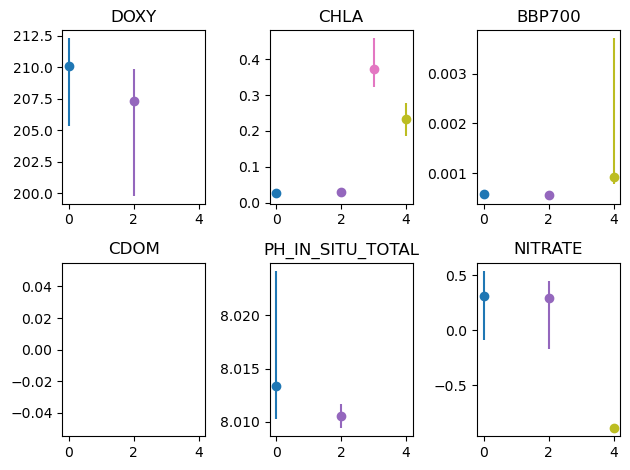

In [37]:
PlotReferenceMaps()

float_flags = float_values.loc[:,'FLAG'].unique()
float_flags = float_flags[np.where(np.isnan(float_flags)==False)]


fig = plt.figure()

for pi in np.arange(len(parameter_list)):

    param = parameter_list[pi]

    if pi == 0:
        ax = fig.add_subplot(2,3,int(pi+1))
    else:
        ax = fig.add_subplot(2,3,int(pi+1), sharex = ax)
                         
    for fi in float_flags:
        subset = float_values.loc[float_values.loc[:,'FLAG']==fi,:]
        y = subset.loc[:,param+'_FLOAT'].median()
        y_min = y-subset.loc[:,param+'_FLOAT'].quantile(0.25)
        y_max = subset.loc[:,param+'_FLOAT'].quantile(0.75)-y
    
        ax.scatter(fi, y, c = fi, vmin = 0, vmax =optimum_k-1, cmap = cmap )
        ax.errorbar(fi, y, yerr=np.array([[y_min], [y_max]]), color = cmapp[int(fi),:])
    
    ax.set_title(parameter_list[pi])
fig.tight_layout()